## Why data preprocessing in ML and DL?
1. Preventing early saturation of non-linear activation functions like sigmoid function.      2. Assuring that all input is in same range of values etc.

### Vanishing Gradient Problem
If we use a sigmoid function for our activation function, then, if z (the output of the neuron prior to the activate function) is very large or very small, the derivative will be approximately 0. In consequence, when we go to compute the gradient and update the weights, the change will be so infinitesimally small that the model won’t improve. The latter is known as the vanishing gradient problem.

In normalizing the output of the neuron before it enters the activation function, we can ensure it remains close to 0 where the derivative highest.

#### Standard deviation is equal to the square root of the variance.

### Need for batch normalization
The distribution of the activations in intermediate layers is constantly changing during training. This slows down the training process because each layer must learn to adapt themselves to a new distribution in every training step. This problem is known as internal covariate shift.

### Batch Normalization
Batch normalization is a method we can use to normalize the inputs of each layer, in order to fight the internal covariate shift problem.
During training time, a batch normalization layer does the following:

1. Calculate the mean and variance of the layers input.

2. Normalize the layer inputs using the previously calculated batch statistics.

3. Scale and shift in order to obtain the output of the layer.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import time

In [2]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.datasets import fashion_mnist
from keras.utils import normalize, to_categorical

In [3]:
# Checking if GPU available
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Loading Data

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print("Train x:",x_train.shape)
print("Train y:",y_train.shape)
print("Test x:",x_test.shape)
print("Test y:",y_test.shape)

Train x: (60000, 28, 28)
Train y: (60000,)
Test x: (10000, 28, 28)
Test y: (10000,)


Image label:  Trouser


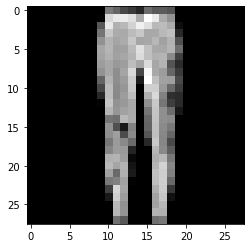

In [5]:
# Labels and data visualization
labels = ["T-shirt/top", 
          "Trouser",    
          "Pullover",  
          "Dress",     
          "Coat",      
          "Sandal",    
          "Shirt",     
          "Sneaker",   
          "Bag",       
          "Ankle boot"]
def show_image(ind): # Display image
    plt.imshow(x_train[ind], cmap='gray')    
    print("Image label: ", labels[y_train[ind]])

show_image(78)

# Data Preprocessing

In [6]:
# Normalization

# axis: axis along which to normalize
x_train = normalize(x_train, axis=1)
x_test = normalize(x_test, axis=1)

In [7]:
# Validation data
(x_train, x_valid) = x_train[10000:], x_train[:10000] 
(y_train, y_valid) = y_train[10000:], y_train[:10000]

# Reshape input data from (28, 28) to (28, 28, 1)
# tf.expan_dims: Returns a tensor with an additional dimension 
# inserted at index axis
x_train = tf.expand_dims(x_train, axis = -1)
x_valid = tf.expand_dims(x_valid, axis = -1)
x_test = tf.expand_dims(x_test, axis = -1)

# One-hot encoding of the integer labels to convert to binary class 
# matrix

# tf.keras.utils.to_categorical: Converts a class vector (integers) to 
# binary class matrix. 
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test = to_categorical(y_test, 10)


# Print training, validation, test set shape
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_valid shape:", x_valid.shape, "y_valid shape:", y_valid.shape)
print("x_test shape:", x_test.shape, "y_test shape:", y_test.shape)


# Print the number of training, validation, and test datasets
print(x_train.shape[0], 'samples in train set')
print(x_valid.shape[0], 'samples in validation set')
print(x_test.shape[0], 'samples in test set')

x_train shape: (50000, 28, 28, 1) y_train shape: (50000, 10)
x_valid shape: (10000, 28, 28, 1) y_valid shape: (10000, 10)
x_test shape: (10000, 28, 28, 1) y_test shape: (10000, 10)
50000 samples in train set
10000 samples in validation set
10000 samples in test set


In [8]:
def model_build(batch_normalization, activation):
    s = time.time()
    model = tf.keras.Sequential()

    # Must define input shape in first layer of the neural network
    
    # Padding: With "SAME" padding, if you use a stride of 1, layer's
    # outputs will have same spatial dimensions as its inputs. With 
    # "VALID" padding, there's no "made-up" padding inputs. The layer 
    # only uses valid input data.
    
    # kernel_size: An integer or tuple/list of 2 integers, specifying 
    # height and width of 2D convolution window. Can be a single 
    # integer to specify same value for all spatial dimensions.
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, 
        padding='same', activation=activation, input_shape=(28,28,1))) 
    
    if batch_normalization:
        model.add(BatchNormalization())

    # pool_size	integer or tuple of 2 integers, window size over which
    # to take the maximum. (2, 2) will take the max value over a 2x2 
    # pooling window. If only one integer is specified, same window 
    # length will be used for both dimensions.
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, 
                            padding='same', activation=activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation=activation))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    # Take a look at the model summary
    e = time.time()
    print('Model Generation time: ', e-s)
    model.summary()
    return model

In [9]:
model = model_build(True, 'sigmoid')

Model Generation time:  72.73888182640076
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_

In [10]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [11]:
from keras.callbacks import ModelCheckpoint
# ModelCheckpoint: Callback to save Keras model or model weights at
# some frequency.

checkpointer = ModelCheckpoint(
    filepath='2_batch_norm_model.weights.best.hdf5', 
    verbose = 1, save_best_only=True)

s = time.time()
model_history = model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=10,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])

e = time.time()
print('Model Training time: ', e-s)


"""ModelCheckpoint callback is used in conjunction with training using
model.fit() to save a model or weights (in a checkpoint file) at some
interval, so model or weights can be loaded later to continue training
from state saved."""

Epoch 1/10
782/782 [==============================] - ETA: 0s - loss: 0.5499 - accuracy: 0.7987
Epoch 00001: val_loss improved from inf to 0.58149, saving model to 2_batch_norm_model.weights.best.hdf5
782/782 [==============================] - 21s 27ms/step - loss: 0.5499 - accuracy: 0.7987 - val_loss: 0.5815 - val_accuracy: 0.7606
Epoch 2/10
780/782 [============================>.] - ETA: 0s - loss: 0.3863 - accuracy: 0.8583
Epoch 00002: val_loss improved from 0.58149 to 0.47831, saving model to 2_batch_norm_model.weights.best.hdf5
782/782 [==============================] - 21s 27ms/step - loss: 0.3863 - accuracy: 0.8583 - val_loss: 0.4783 - val_accuracy: 0.8036
Epoch 3/10
781/782 [============================>.] - ETA: 0s - loss: 0.3473 - accuracy: 0.8739
Epoch 00003: val_loss improved from 0.47831 to 0.30559, saving model to 2_batch_norm_model.weights.best.hdf5
782/782 [==============================] - 21s 27ms/step - loss: 0.3473 - accuracy: 0.8739 - val_loss: 0.3056 - val_accurac

'ModelCheckpoint callback is used in conjunction with training using\nmodel.fit() to save a model or weights (in a checkpoint file) at some\ninterval, so model or weights can be loaded later to continue training\nfrom state saved.'

[]

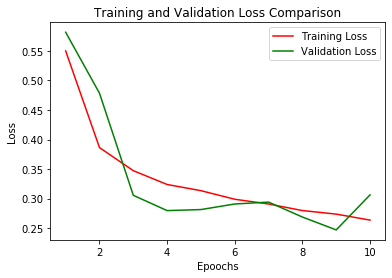

In [12]:
# Training and Validation Loss Comparison
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoochs')
plt.ylabel('Loss')
plt.legend()
plt.plot()

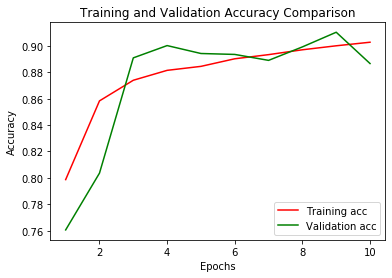

In [13]:
# Training and Validation Accuracy comparison
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
# Load the weights with the best validation accuracy
model.load_weights('2_batch_norm_model.weights.best.hdf5')

In [15]:
# Evaluate the model on test set
s = time.time()
score = model.evaluate(x_test, y_test, verbose=0)
e = time.time()
print('Model Prediction time: ', e-s)


# Print test accuracy
print('\n', 'Test accuracy:', score[1])

Model Prediction time:  2.2132203578948975

 Test accuracy: 0.900600016117096


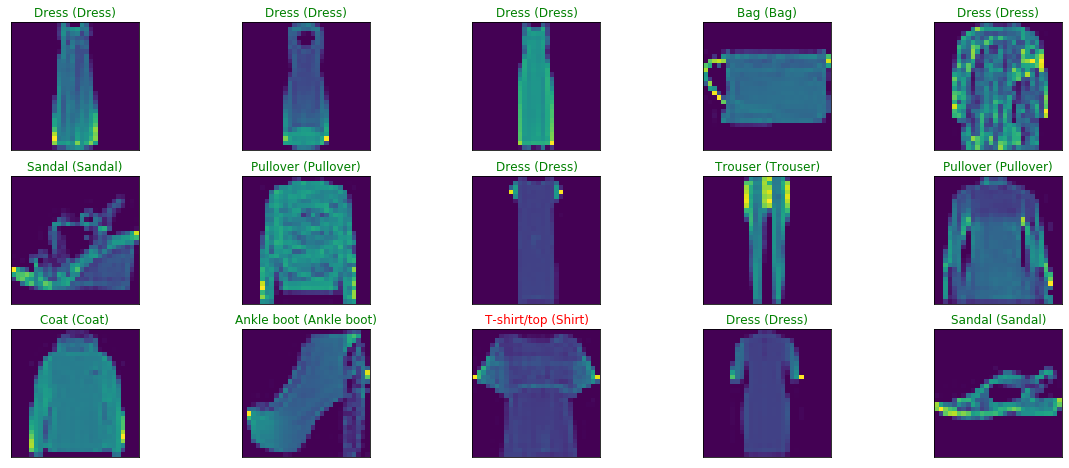

In [16]:
y_hat = model.predict(x_test)

# Plot a random sample of 10 test images, their predicted labels and
# ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                        labels[true_index]),
            color=("green" if predict_index == true_index else "red"))

# Performance Comparison

In [17]:
# Model 1
# Batch Normalization: False
# Activation: relu
# Loss: categorical_crossentropy
# Model Generation Time: 
"Model Generation time:  68.1452419757843"

# Model summary:
"""
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               401664    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
=================================================================
Total params: 412,778
Trainable params: 412,778
Non-trainable params: 0
"""

# Model Training Time: 
"Model Training time:  206.23725581169128"
# Model Training:
"""
Epoch 1/10
782/782 [==============================] - ETA: 0s - loss: 0.6423 - accuracy: 0.7598
Epoch 00001: val_loss improved from inf to 0.40693, saving model to 2_batch_norm/model.weights.best.hdf5
782/782 [==============================] - 20s 25ms/step - loss: 0.6423 - accuracy: 0.7598 - val_loss: 0.4069 - val_accuracy: 0.8494

Epoch 9/10
781/782 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.8902
Epoch 00009: val_loss improved from 0.25388 to 0.25069, saving model to 2_batch_norm/model.weights.best.hdf5
782/782 [==============================] - 23s 30ms/step - loss: 0.2969 - accuracy: 0.8901 - val_loss: 0.2507 - val_accuracy: 0.9049

Epoch 10/10
780/782 [============================>.] - ETA: 0s - loss: 0.2889 - accuracy: 0.8907
Epoch 00010: val_loss did not improve from 0.25069
782/782 [==============================] - 19s 24ms/step - loss: 0.2889 - accuracy: 0.8908 - val_loss: 0.2530 - val_accuracy: 0.9046

"""

# Model Testing Time: 
"Model Prediction time:  1.8418166637420654"
# Model Testing:
"Test accuracy: 0.8057000041007996"

'Test accuracy: 0.8057000041007996'

In [18]:
# Model 2
# Batch Normalization: True
# Activation: relu
# Loss: categorical_crossentropy
# Model Generation Time: 
"Model Generation time:  78.46980929374695"

# Model summary:
"""
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               401664    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
=================================================================
Total params: 413,162
Trainable params: 412,970
Non-trainable params: 192"""

# Model Training Time:
"Model Training time:  241.26198720932007"

# Model Training:
"""
Epoch 1/10
782/782 [==============================] - ETA: 0s - loss: 0.6200 - accuracy: 0.7788
Epoch 00001: val_loss improved from inf to 0.38009, saving model to 2_batch_norm_model.weights.best.hdf5
782/782 [==============================] - 24s 30ms/step - loss: 0.6200 - accuracy: 0.7788 - val_loss: 0.3801 - val_accuracy: 0.8596
Epoch 10/10
781/782 [============================>.] - ETA: 0s - loss: 0.2842 - accuracy: 0.8942
Epoch 00010: val_loss improved from 0.26276 to 0.23875, saving model to 2_batch_norm_model.weights.best.hdf5
782/782 [==============================] - 24s 31ms/step - loss: 0.2841 - accuracy: 0.8943 - val_loss: 0.2387 - val_accuracy: 0.9141

"""

# Model Testing Time:
"Model Prediction time:  2.018071174621582"

# Model Testing:
"Test accuracy: 0.902999997138977"

'Test accuracy: 0.902999997138977'

In [19]:
# Model 3
# Batch Normalization: False
# Activation: sigmoid
# Loss: categorical_crossentropy
# Model Generation Time: 
"Model Generation time:  80.42562103271484"

# Model summary:
"""
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               401664    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
=================================================================
Total params: 412,778
Trainable params: 412,778
Non-trainable params: 0
"""

# Model Training Time: 
"Model Training time:  201.48682951927185"
# Model Training:
"""
Epoch 1/10
782/782 [==============================] - ETA: 0s - loss: 2.3156 - accuracy: 0.0995
Epoch 00001: val_loss improved from inf to 2.30267, saving model to 2_batch_norm_model.weights.best.hdf5
782/782 [==============================] - 23s 29ms/step - loss: 2.3156 - accuracy: 0.0995 - val_loss: 2.3027 - val_accuracy: 0.1022
Epoch 10/10
779/782 [============================>.] - ETA: 0s - loss: 0.4561 - accuracy: 0.8280
Epoch 00010: val_loss improved from 0.40228 to 0.38204, saving model to 2_batch_norm_model.weights.best.hdf5
782/782 [==============================] - 18s 23ms/step - loss: 0.4563 - accuracy: 0.8279 - val_loss: 0.3820 - val_accuracy: 0.8526
"""

# Model Testing Time:
"Model Prediction time:  1.7630040645599365"

# Model Testing:
"Test accuracy: 0.8482000231742859"

'Test accuracy: 0.8482000231742859'

In [21]:
# Model 4
# Batch Normalization: True
# Activation: sigmoid
# Loss: categorical_crossentropy
# Model Generation Time: 
"Model Generation time:  72.73888182640076"

# Model summary:
"""
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               401664    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
=================================================================
Total params: 412,778
Trainable params: 412,778
Non-trainable params: 0
"""

# Model Training Time: 
"Model Training time:  218.68054509162903"

# Model Training:
"""
Epoch 1/10
782/782 [==============================] - ETA: 0s - loss: 0.5499 - accuracy: 0.7987
Epoch 00001: val_loss improved from inf to 0.58149, saving model to 2_batch_norm_model.weights.best.hdf5
782/782 [==============================] - 21s 27ms/step - loss: 0.5499 - accuracy: 0.7987 - val_loss: 0.5815 - val_accuracy: 0.7606
Epoch 9/10
782/782 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.9000
Epoch 00009: val_loss improved from 0.26887 to 0.24706, saving model to 2_batch_norm_model.weights.best.hdf5
782/782 [==============================] - 22s 29ms/step - loss: 0.2738 - accuracy: 0.9000 - val_loss: 0.2471 - val_accuracy: 0.9103
Epoch 10/10
780/782 [============================>.] - ETA: 0s - loss: 0.2635 - accuracy: 0.9028
Epoch 00010: val_loss did not improve from 0.24706
782/782 [==============================] - 24s 30ms/step - loss: 0.2637 - accuracy: 0.9027 - val_loss: 0.3064 - val_accuracy: 0.8866
"""

# Model Testing Time:
"Model Prediction time:  2.2132203578948975"

# Model Testing:
"Test accuracy: 0.900600016117096"

'Test accuracy: 0.900600016117096'

# Conclusion

## Competitors:
1. relu activation without batch normalization

2. relu activation with batch normalization

3. sigmoid activation without batch normalization

4. sigmoid activation with batch normalization

## Model Generation Time:
1(68) < 4(72) < 2(78) < 3(80)

## Model Training Time:
3(201) < 1(206) < 4(218) < 2(241)

## Maxm Validation Accuracy:
3(0.8526) < 1(0.9049) < 4(0.9103) < 2(0.9141)

## Testing Accuracy:
1(0.805) < 3(0.848) < 4(0.900) < 2(0.902)

## Maxm Training Accuracy:
3(0.8280) < 1(0.8908) < 2(0.893) < 4(0.9027)


# Result:
Best to use: relu with batch normalization > then sigmoid with batch normalization